# Traffic Sign Classification
This notebook demonstrates traffic sign classification using a Convolutional Neural Network (CNN). We'll walk through the process step-by-step, from image preprocessing to the final traffic sign classification. Gradually, we'll see that not only how to improve the accuracy of the model but also how to improve its performance.

In [ ]:
# Cloning the Github for the Dataset
!git clone 'https://bitbucket.org/jadslim/german-traffic-signs'

Cloning into 'german-traffic-signs'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 117.80 MiB | 10.41 MiB/s, done.
Updating files: 100% (4/4), done.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.optimizers import Adam
import pickle
import pandas as pd
import random
import cv2

In [ ]:
# To generate same random numbers on multiple executions of the code
np.random.seed(0)

## 1. Data Initialization

In [ ]:
# Load the pickled data files containing training, validation, and test sets
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

In [ ]:
print(type(train_data))

<class 'dict'>


In [ ]:
train_data.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

- 'features' : Column has values in the pixel representation for each image.
- 'labels' : An array of labels which labels each image as belonging to some class.

In [ ]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [ ]:
# Check the total number of elements in each dataset
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
# Verify that the dataset was imported correctly
assert(X_train.shape[0] == y_train.shape[0]), 'The no. of images is not equal to the no. of labels'
assert(X_val.shape[0] == y_val.shape[0]), 'The no. of images is not equal to the no. of labels'
assert(X_test.shape[0] == y_test.shape[0]), 'The no. of images is not equal to the no. of labels'
assert(X_train.shape[1:] == (32, 32, 3)), 'The dimensions of the images are not 32x32x3'
assert(X_val.shape[1:] == (32, 32, 3)), 'The dimensions of the images are not 32x32x3'
assert(X_test.shape[1:] == (32, 32, 3)), 'The dimensions of the images are not 32x32x3'

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

In [ ]:
data

ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                               Stop
15       15                                        No vechiles
16       16           Vechiles over 3.5 metric tons prohibited
17       17                                           No entry
18       18                                    General caution
19       19                        Dangerous curve to the left
20       20                       Dangerous curve to the right
21       21                                       Double curve
22       22                                         Bumpy road
23       23                                      Slippery road
24       24                          Road narrows on the right
25       25                                          Road work
26       26                                    Traffic signals
27       27                                        Pedestrians
28       28                                  Children crossing
29       29                                  Bicycles crossing
30       30                                 Beware of ice/snow
31       31                              Wild animals crossing
32       32                End of all speed and passing limits
33       33                                   Turn right ahead
34       34                                    Turn left ahead
35       35                                         Ahead only
36       36                               Go straight or right
37       37                                Go straight or left
38       38                                         Keep right
39       39                                          Keep left
40       40                               Roundabout mandatory
41       41                                  End of no passing
42       42  End of no passing by vechiles over 3.5 metric ...

There are total 43 numbers of classes.

## 2. Getting Familiar With the Dataset

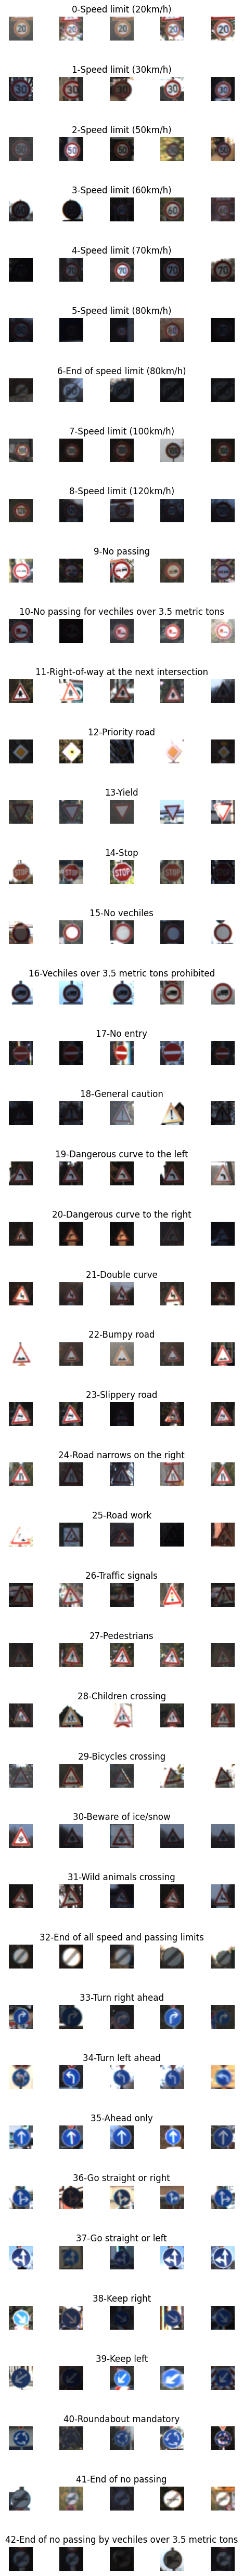

In [ ]:
# Initialize an empty list to store the number of samples per class
num_of_samples = []
# Set the number of columns for the subplot grid and define the total number of classes
cols = 5
num_classes = 43

# Create a figure and axes with a grid of subplots to visualize sample images
fig, axes = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
fig.tight_layout()

# Iterate through each column and each row in the dataset to display sample images
for i in range(cols):
  for j, row in data.iterrows():  # Loop through each row in the DataFrame (each class)
    x_selected = X_train[y_train == j]
    axes[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap('gray'))
    axes[j][i].axis('off')
    if i == 2:
      axes[j][i].set_title(str(j) + '-' + row['SignName'])
      num_of_samples.append(len(x_selected))

Let's find out how many images each class holds.

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


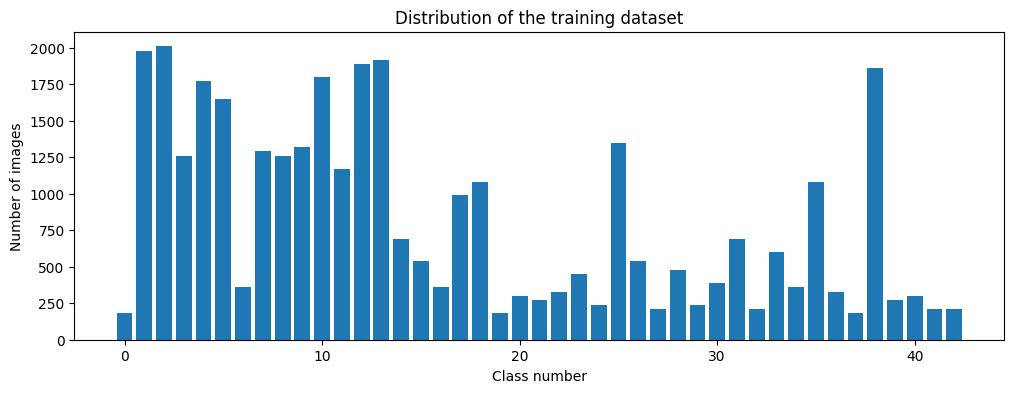

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title('Distribution of the training dataset')
plt.xlabel('Class number')
plt.ylabel('Number of images')
plt.show()

This data is less uniform. Some classes have a larger number of training images belonging to them while some classes have small number of training images. This means, some classes has less data to train with and might return less accurate results.

This can make a lot more difficult for the model to learn properly with a high accuracy rate.

Let's walk through how to train the model on this type of dataset.

In [ ]:
print('Largest dataset has', max(num_of_samples), 'images')
print('Smallest dataset has', min(num_of_samples), 'images')

Largest dataset has 2010 images
Smallest dataset has 180 images


This is a huge difference. Hence, we need to balance our dataset. But, before this we'll train the model on the available dataset and see how it performs.

## 3. Data Preprocessing
- These images have RGB channels, and they contain various signs with a variety of backgrounds and lightening conditions. Each one of them contains unique extra features that make it more difficult to classify them.
- Therefore, we need to preprocess these images to make it easier for the model to classify them.

(32, 32, 3)
41


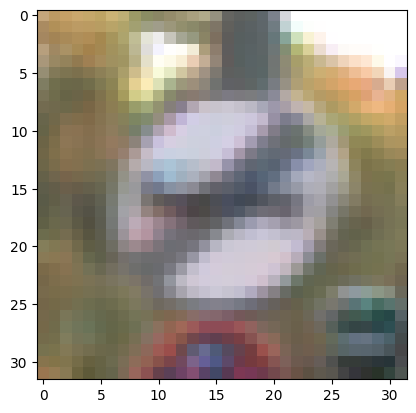

In [ ]:
# Original Image
plt.imshow(X_train[100])
print(X_train[100].shape)
print(y_train[100])

### 3.1. Grayscale Conversion
We convert the image to grayscale to simplify our analysis. Grayscale images have only one color channel, reducing the complexity of image processing algorithms. This can lead to faster processing times and simpler implementations.

(32, 32)


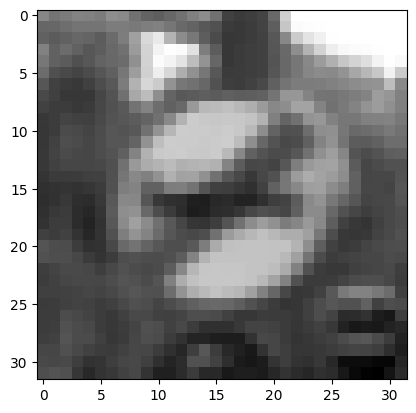

In [ ]:
def gray_scale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = gray_scale(X_train[100])
plt.imshow(img, cmap='gray')
print(img.shape)

### 3.2. Histogram Equalization
Aims to standardize the lightning in all the images. This function only accepts the grayscale images. In this dataset some of the images are very bright and some of them are very dim. After applying Histogram Equalization, all of the images will have similar lightning effect. This process results in higher contrast within the image, which can help with feature extraction.

(32, 32)


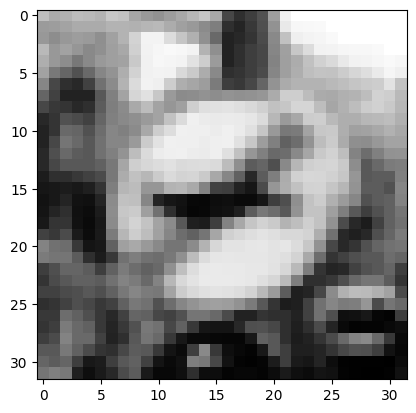

In [ ]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img, cmap='gray')
print(img.shape)

In [ ]:
# Function to process the entire dataset
def preprocessing(img):
  img = gray_scale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


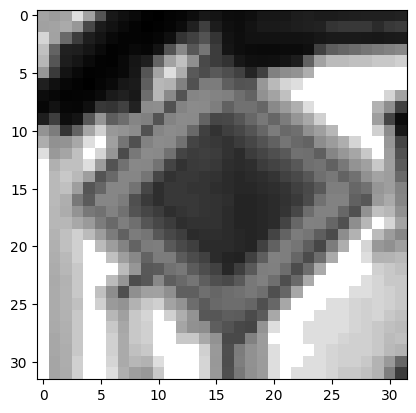

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)], cmap='gray')
print(X_train.shape)

But to process the data in Convolutional Network, we need to add depth to our data. In the case of grayscale images there is 1 channel.

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


### 3.3. 1-Hot Encoding
Perform 1-hot encoding on the label dataset.

In [ ]:
y_train = to_categorical(y_train, num_classes=43)
y_test = to_categorical(y_test, num_classes=43)
y_val = to_categorical(y_val, num_classes=43)

## 4. Training and Validation
Using LeNet Model Architecture to train the model.

In [ ]:
def lenet_model():
  """
  Function to define the LeNet model architecture.

  Returns:
  - model: The compiled LeNet model.
  """
  model = Sequential()

  # unit 1
  model.add(Conv2D(filters=30, kernel_size=(5,5), input_shape=(32,32,1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # unit 2
  model.add(Conv2D(filters=15, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # unit 3
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))

  # unit 4
  model.add(Dense(num_classes, activation='softmax'))

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


def plot_accuracy_and_loss(history):
  """
  Function to plot the accuracy and loss of the model.

  Parameters:
  - history: The training history of the model.
  """
  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  # Plot loss
  axs[0].plot(history.history['loss'])
  axs[0].plot(history.history['val_loss'])
  axs[0].legend(['training', 'validation'])
  axs[0].set_title('Loss')
  axs[0].set_xlabel('epoch')

  # Plot accuracy
  axs[1].plot(history.history['accuracy'])
  axs[1].plot(history.history['val_accuracy'])
  axs[1].legend(['training', 'validation'])
  axs[1].set_title('Accuracy')
  axs[1].set_xlabel('epoch')

  plt.show()


def evaluate_model(model, x_test, y_test, verbose):
  """
  Method to assess the model's performance on the test data.

  Parameters:
  - model: The trained machine learning model.
  - x_test: The test data features.
  - y_test: The corresponding true labels for the test data.
  - verbose: A boolean flag indicating whether to print progress messages during evaluation.
  """
  score = model.evaluate(x_test, y_test, verbose=verbose)
  print('Test Score:', score[0])
  print('Test Accuracy:', score[1])

In [ ]:
model = lenet_model()
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 30)          │             780 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 30)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 15)          │           4,065 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 15)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 540)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │         270,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 296,888 (1.13 MB)

 Trainable params: 296,888 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 173ms/step - accuracy: 0.2525 - loss: 2.8281 - val_accuracy: 0.7510 - val_loss: 0.7701
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8028 - loss: 0.6039 - val_accuracy: 0.8791 - val_loss: 0.4051
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8895 - loss: 0.3354 - val_accuracy: 0.8896 - val_loss: 0.3541
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9171 - loss: 0.2552 - val_accuracy: 0.8991 - val_loss: 0.3297
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9373 - loss: 0.1922 - val_accuracy: 0.9063 - val_loss: 0.3389
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9425 - loss: 0.1721 - val_accuracy: 0.9100 - val_loss: 0.3348
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9512 - loss: 0.1494 - val_accuracy: 0.9107 - val_loss: 0.3083
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9483 - loss: 0.1542 - val_accuracy: 0.9224 - val_lo

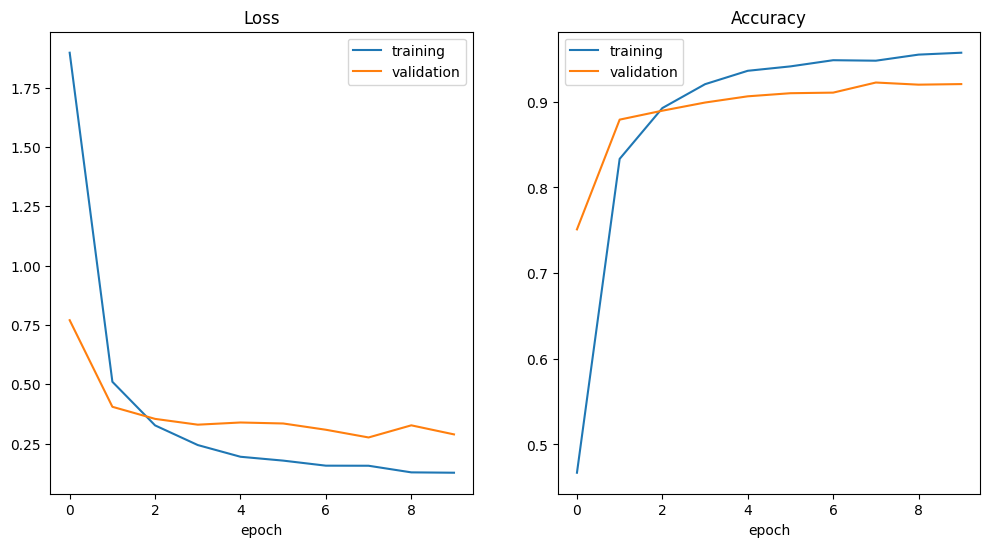

In [ ]:
plot_accuracy_and_loss(history)

As the validation accuracy is trailing behind the training accuracy means that the model is overfitted.

Now, run the model on test data.

In [ ]:
evaluate_model(model=model, x_test=X_test, y_test=y_test, verbose=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9138 - loss: 0.3502
Test Score: 0.3506276607513428
Test Accuracy: 0.9130641222000122


There are two main issues to deal with:
1. The Accuracy is not as high as expected.
2. The model seems to be overfitting the training data.

## 5. Fine-tuning Model
- Fine-tuning is a very specific process that is unique for each deep learning task.
- It can improve models performance significantly.

### 5.1. Step-1
When working with a complex dataset, try to keep the learning rate small. So that, the neural network can learn more effectively resulting into an increased accuracy.

In [ ]:
def lenet_model():
  model = Sequential()

  # unit 1
  model.add(Conv2D(filters=30, kernel_size=(5,5), input_shape=(32,32,1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # unit 2
  model.add(Conv2D(filters=15, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # unit 3
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))

  # unit 4
  model.add(Dense(num_classes, activation='softmax'))

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = lenet_model()
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 30)          │             780 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 30)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 15)          │           4,065 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 15)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 540)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │         270,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 296,888 (1.13 MB)

 Trainable params: 296,888 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.1802 - loss: 3.1518 - val_accuracy: 0.6685 - val_loss: 1.1432
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7042 - loss: 0.9618 - val_accuracy: 0.8288 - val_loss: 0.5428
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8476 - loss: 0.5018 - val_accuracy: 0.8778 - val_loss: 0.3989
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8998 - loss: 0.3288 - val_accuracy: 0.8984 - val_loss: 0.3375
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9245 - loss: 0.2577 - val_accuracy: 0.9020 - val_loss: 0.3128
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9421 - loss: 0.1961 - val_accuracy: 0.9107 - val_loss: 0.2801
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9521 - loss: 0.1691 - val_accuracy: 0.9197 - val_loss: 0.2591
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9579 - loss: 0.1343 - val_accuracy: 0.9243 - val_loss

The training accuracy increased while the test accuracy suffered a bit. This is how a small change can affect the model.

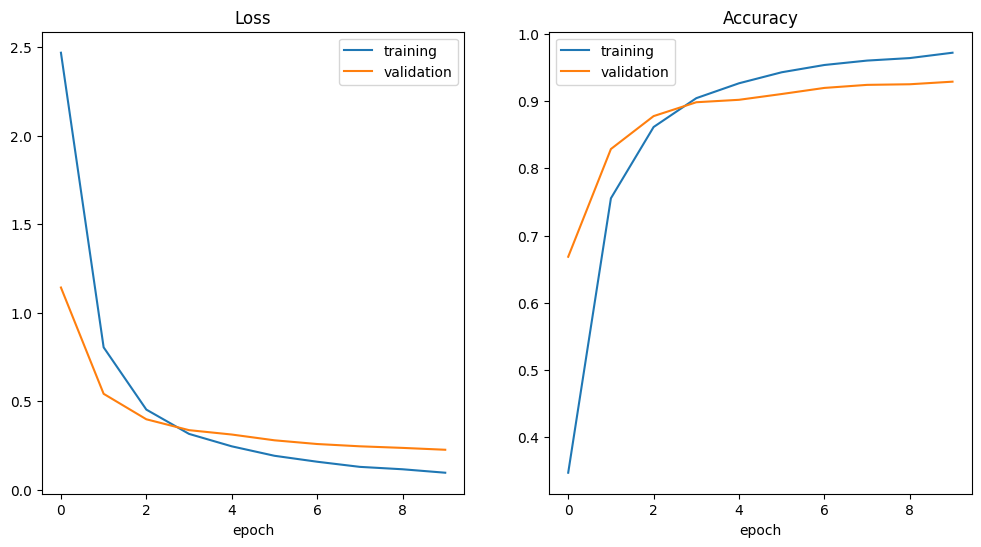

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
evaluate_model(model=model, x_test=X_test, y_test=y_test, verbose=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9121 - loss: 0.3402
Test Score: 0.34317344427108765
Test Accuracy: 0.9108471870422363


### 5.2. Step-2
Increasing the number of filters inside the Convolutional Layer can help the network to extract more features from the images resulting into an improved accuracy.

In [ ]:
def lenet_model():
  model = Sequential()

  # unit 1
  model.add(Conv2D(filters=60, kernel_size=(5,5), input_shape=(32,32,1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # unit 2
  model.add(Conv2D(filters=30, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # unit 3
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))

  # unit 4
  model.add(Dense(num_classes, activation='softmax'))

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = lenet_model()
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 30)          │          16,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1080)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 500)                 │         540,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 579,833 (2.21 MB)

 Trainable params: 579,833 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.1876 - loss: 3.1044 - val_accuracy: 0.6812 - val_loss: 1.0745
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7169 - loss: 0.9162 - val_accuracy: 0.8385 - val_loss: 0.5194
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8627 - loss: 0.4493 - val_accuracy: 0.8760 - val_loss: 0.3945
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9147 - loss: 0.2838 - val_accuracy: 0.8968 - val_loss: 0.3294
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9371 - loss: 0.2165 - val_accuracy: 0.9261 - val_loss: 0.2580
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9516 - loss: 0.1671 - val_accuracy: 0.9193 - val_loss: 0.2509
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9620 - loss: 0.1343 - val_accuracy: 0.9349 - val_loss: 0.2082
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9673 - loss: 0.1048 - val_accuracy: 0.9281 - val_los

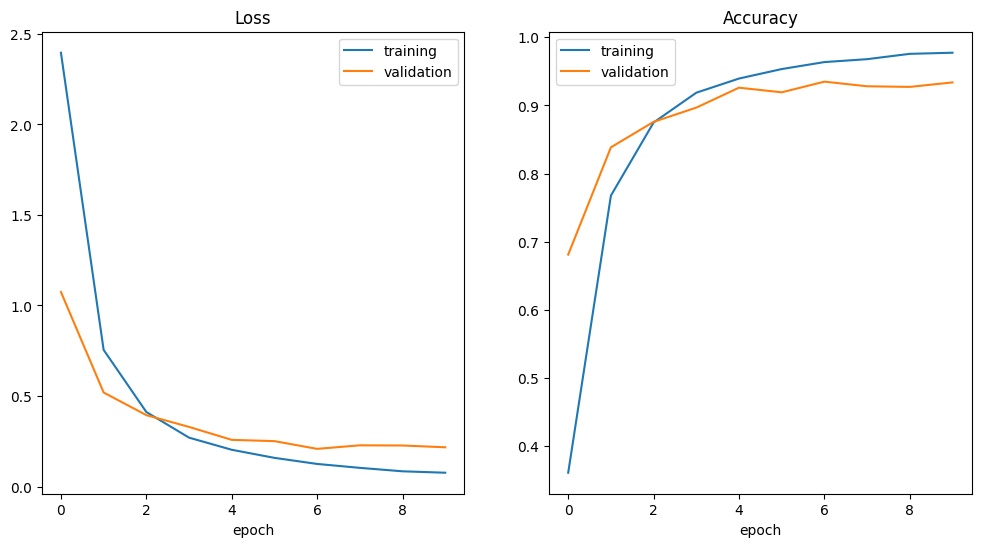

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
evaluate_model(model=model, x_test=X_test, y_test=y_test, verbose=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9244 - loss: 0.2882
Test Score: 0.3004619777202606
Test Accuracy: 0.9219319224357605


### 5.3. Step-3
Increase the number of convolution layers.

In [ ]:
def modified_model():
  model = Sequential()

  # unit 1
  model.add(Conv2D(filters=60, kernel_size=(5,5), input_shape=(32,32,1), activation='relu'))
  model.add(Conv2D(filters=60, kernel_size=(5,5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # unit 2
  model.add(Conv2D(filters=30, kernel_size=(3,3), activation='relu'))
  model.add(Conv2D(filters=30, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # unit 3
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))

  # unit 4
  model.add(Dense(num_classes, activation='softmax'))

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = modified_model()
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 60)          │          90,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 10, 10, 30)          │          16,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 30)            │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.2547 - loss: 2.8133 - val_accuracy: 0.8537 - val_loss: 0.5001
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8558 - loss: 0.4794 - val_accuracy: 0.9213 - val_loss: 0.2551
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9289 - loss: 0.2355 - val_accuracy: 0.9410 - val_loss: 0.1929
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9579 - loss: 0.1395 - val_accuracy: 0.9587 - val_loss: 0.1593
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9680 - loss: 0.1005 - val_accuracy: 0.9585 - val_loss: 0.1339
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9774 - loss: 0.0740 - val_accuracy: 0.9603 - val_loss: 0.1329
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9810 - loss: 0.0605 - val_accuracy: 0.9664 - val_loss: 0.1114
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9838 - loss: 0.0496 - val_accuracy: 0.9649 - val_los

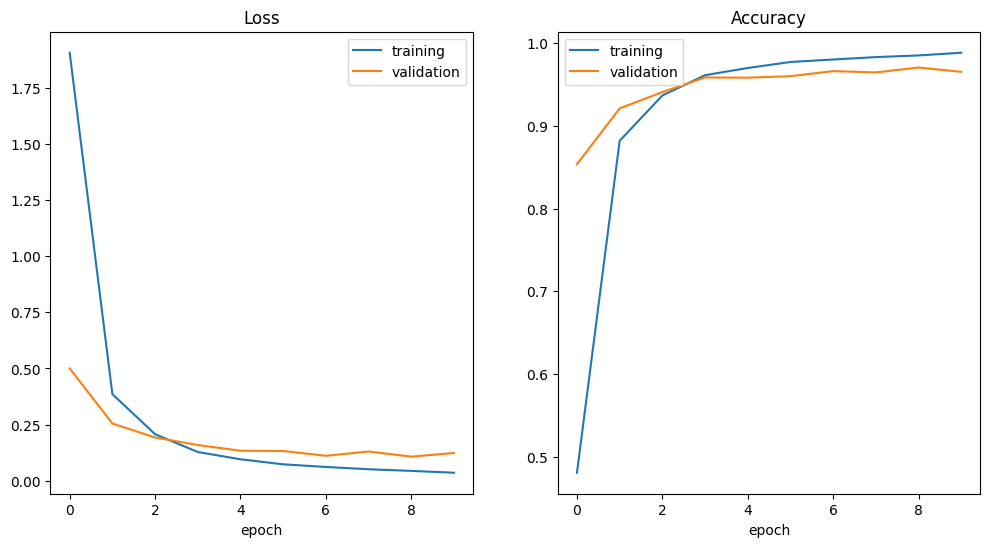

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
evaluate_model(model=model, x_test=X_test, y_test=y_test, verbose=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9479 - loss: 0.2105
Test Score: 0.19921131432056427
Test Accuracy: 0.9477434754371643


- This model improved both the training as well as the validation accuracy. However, still the overfitting issue is present.
- This can be prevented by adding more dropout layers.

### 5.4. Step-4
Add Dropout Layers to deal with the overfitting.

In [ ]:
def modified_model():
  model = Sequential()

  # unit 1
  model.add(Conv2D(filters=60, kernel_size=(5,5), input_shape=(32,32,1), activation='relu'))
  model.add(Conv2D(filters=60, kernel_size=(5,5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # unit 2
  model.add(Conv2D(filters=30, kernel_size=(3,3), activation='relu'))
  model.add(Conv2D(filters=30, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))

  # unit 3
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))

  # unit 4
  model.add(Dense(num_classes, activation='softmax'))

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = modified_model()
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 60)          │          90,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 12, 12, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 10, 10, 30)          │          16,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 30)            │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.1895 - loss: 3.0741 - val_accuracy: 0.7964 - val_loss: 0.7138
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7466 - loss: 0.8274 - val_accuracy: 0.9082 - val_loss: 0.2966
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8608 - loss: 0.4521 - val_accuracy: 0.9422 - val_loss: 0.1966
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9031 - loss: 0.3133 - val_accuracy: 0.9574 - val_loss: 0.1652
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9209 - loss: 0.2503 - val_accuracy: 0.9594 - val_loss: 0.1346
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9388 - loss: 0.1952 - val_accuracy: 0.9680 - val_loss: 0.1093
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9489 - loss: 0.1609 - val_accuracy: 0.9746 - val_loss: 0.0919
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9547 - loss: 0.1444 - val_accuracy: 0.9755 - val_los

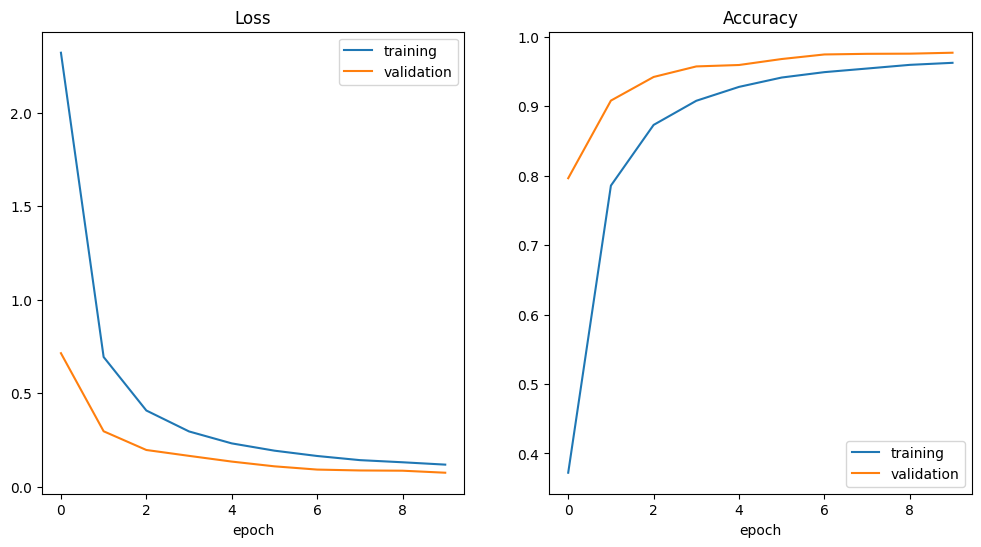

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
evaluate_model(model=model, x_test=X_test, y_test=y_test, verbose=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9572 - loss: 0.1492
Test Score: 0.15180160105228424
Test Accuracy: 0.9558194875717163


- This is how, solved the issue of overfitting.
- The validation loss is always lower than the training loss.
- And, the validation accuracy is now greater than the training accuracy.

Increased test accuracy shows that the model is able to handle new data pretty well.

## 6. Testing
Now, test the model on different traffic symbols.

In [ ]:
import requests
from PIL import Image

In [ ]:
image_urls = ["https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg",
               "https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg",
               "https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg",
               "https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg",
               "https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg"]

In [ ]:
import requests
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

def predict_and_display(model, image_urls):
  for image_url in image_urls:
    try:
      # Download and open the image
      r = requests.get(image_url, stream=True)
      r.raise_for_status()  # Ensure the request was successful
      original_image = Image.open(r.raw)  # Convert image to RGB format (3 channels)

      # Preprocess the input image
      image = np.asarray(original_image)
      image = cv2.resize(image, (32, 32))  # Assuming your model expects 32x32 images
      preprocessed_image = preprocessing(image)  # Replace with your specific preprocessing function
      preprocessed_image = preprocessed_image.reshape(32, 32, 1)

      # Predict class
      predicted_class_index = np.argmax(model.predict(np.expand_dims(preprocessed_image, axis=0)))
      class_name = data['SignName'][predicted_class_index]

      # Display the image with predicted class name
      plt.imshow(original_image)
      plt.title(f"Predicted Class: {class_name}")
      plt.axis('off')  # Hide x and y axes labels
      plt.show()

    except requests.exceptions.RequestException as e:
        print(f"An error occurred while downloading the image: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


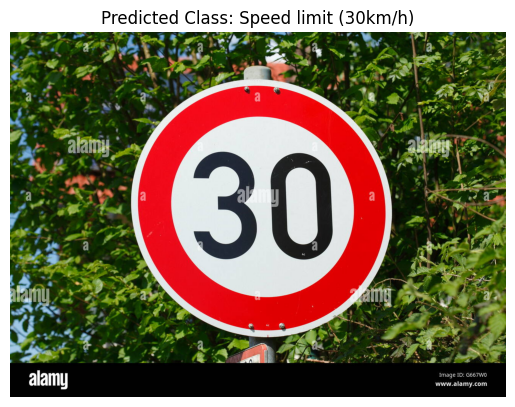

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


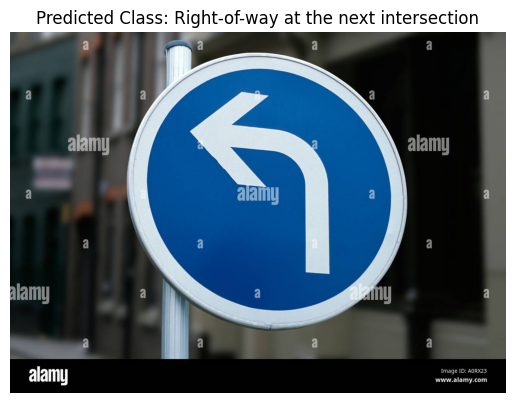

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


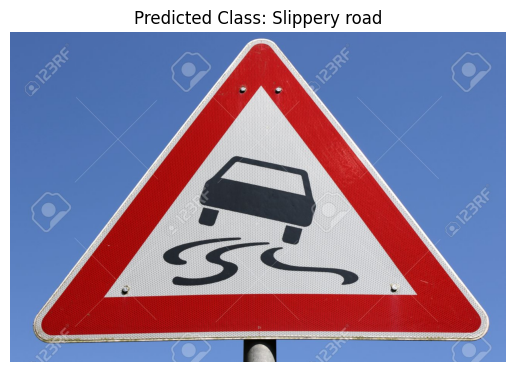

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


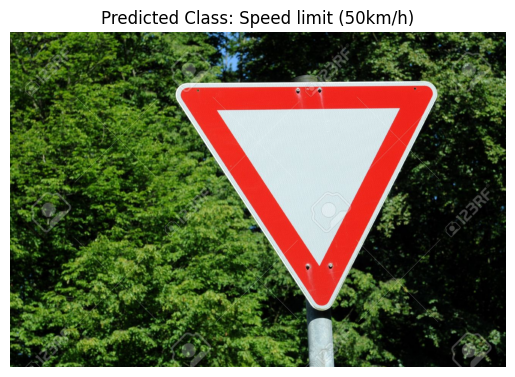

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


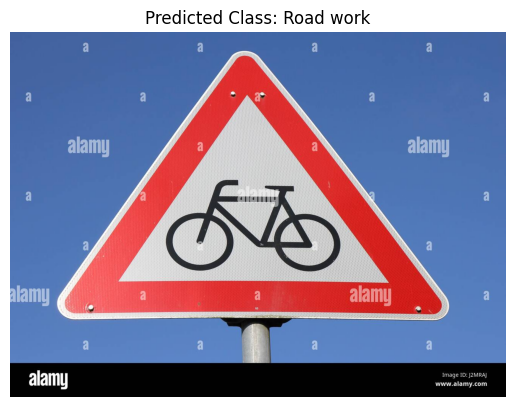

In [ ]:
predict_and_display(model, image_urls)

The model is not performing upto the standards despite introducing modifications to the model, increasing the model's accuracy.

Out of the 5 images, it only predicted 2 images correctly. This is due to the imbalanced data. Hence, performing Data Augmentation on the dataset.

## 7. Data Augmentation
To increase the model's accuracy and performance further more.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Augmentations Performed:
1. width_shift_range :
- When ranges between 0 to 1 (It defines the maximun shift possible in percentage).
- When the value is greater than 1, it refers the shift in the number of pixels.
- It refers to the fraction of the image that can be shifted horizontally.
2. height_shift_range :
- Similar to the 'width_shift_range', the only difference is that it refers to a vertical translation within the image.
3. zoom_range :
- Degree of zoom can be defined with a float value between 0 and 1.
- Maximum outer zoom defined by [1-] and the maximum inner zoom defined by [1+].
4. shear_range :
- Possible in both X and Y direction.
- It refers to the magnitude of the shear angle and degrees.
5. rotation_range :
- It simply rotates the image by a certain value of degrees.

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)

In [ ]:
datagen.fit(X_train)

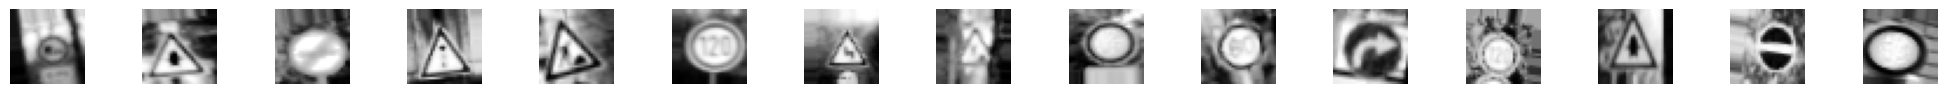

In [ ]:
# Requesting the generator to create new images
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axes = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

# Displaying some of the Augmented Images
for i in range(15):
  axes[i].imshow(X_batch[i].reshape(32, 32), cmap='gray')
  axes[i].axis('off')

In [ ]:
model = modified_model()
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 24, 24, 60)          │          90,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 12, 12, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 10, 10, 30)          │          16,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 8, 8, 30)            │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                    steps_per_epoch=2000,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    shuffle=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 688/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.2191 - loss: 2.8719

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.3347 - loss: 2.3938 - val_accuracy: 0.8626 - val_loss: 0.4953
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.6993 - loss: 0.9790 - val_accuracy: 0.9338 - val_loss: 0.2006
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7997 - loss: 0.6442 - val_accuracy: 0.9630 - val_loss: 0.1311
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8450 - loss: 0.4984 - val_accuracy: 0.9662 - val_loss: 0.1131
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8691 - loss: 0.4126 - val_accuracy: 0.9823 - val_loss: 0.0627
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8843 - loss: 0.3667 - val_accuracy: 0.9830 - val_loss: 0.0571
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8989 - loss: 0.3262 - val_accuracy: 0.9744 - val_loss: 0.0765
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9091 - loss: 0.2900 - va

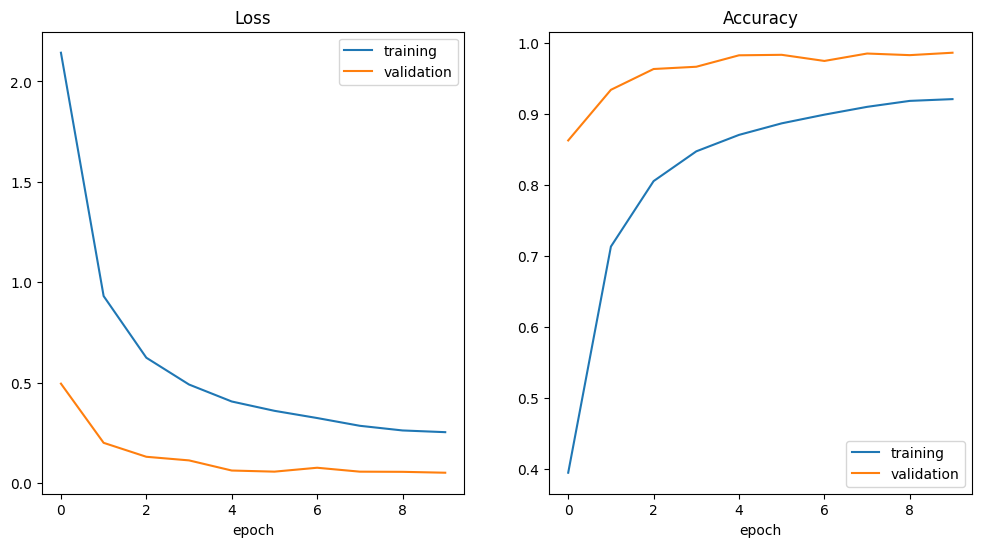

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
evaluate_model(model=model, x_test=X_test, y_test=y_test, verbose=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9564 - loss: 0.1562
Test Score: 0.15655609965324402
Test Accuracy: 0.9573238492012024


 As the gap between the training and validation loss is huge, comment out the dropout layer.

In [ ]:
def modified_model():
  model = Sequential()

  # unit 1
  model.add(Conv2D(filters=60, kernel_size=(5,5), input_shape=(32,32,1), activation='relu'))
  model.add(Conv2D(filters=60, kernel_size=(5,5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # unit 2
  model.add(Conv2D(filters=30, kernel_size=(3,3), activation='relu'))
  model.add(Conv2D(filters=30, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  # model.add(Dropout(0.5))

  # unit 3
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  # model.add(Dropout(0.5))

  # unit 4
  model.add(Dense(num_classes, activation='softmax'))

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = modified_model()

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                    steps_per_epoch=2000,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    shuffle=1)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.5213 - loss: 1.7129 - val_accuracy: 0.9290 - val_loss: 0.2296
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8899 - loss: 0.3609 - val_accuracy: 0.9503 - val_loss: 0.1474
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9339 - loss: 0.2146 - val_accuracy: 0.9751 - val_loss: 0.0833
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9524 - loss: 0.1541 - val_accuracy: 0.9823 - val_loss: 0.0638
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9592 - loss: 0.1290 - val_accuracy: 0.9741 - val_loss: 0.0769
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9662 - loss: 0.1078 - val_accuracy: 0.9664 - val_loss: 0.1315
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9701 - loss: 0.0931 - val_accuracy: 0.9844 - val_loss: 0.0479
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9737 - loss: 

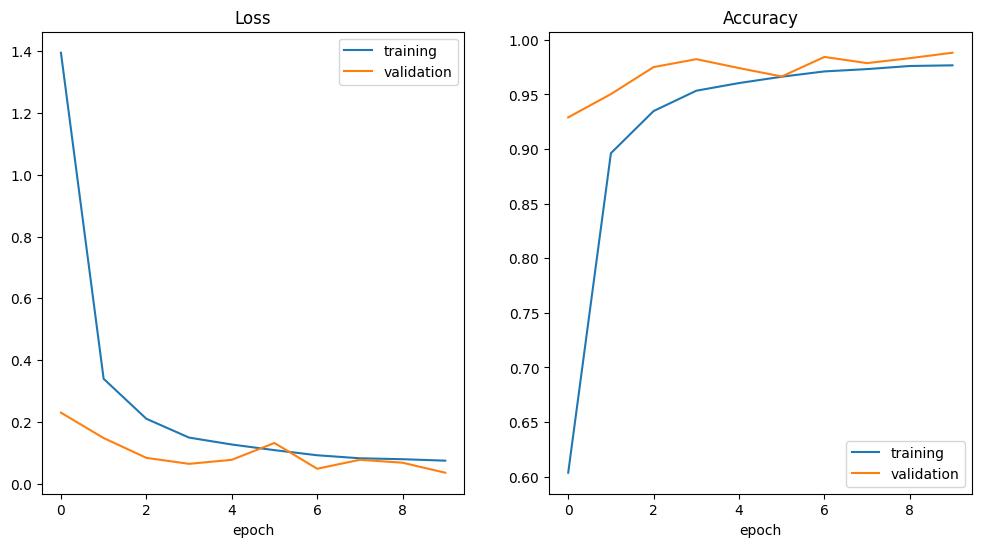

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
evaluate_model(model=model, x_test=X_test, y_test=y_test, verbose=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9719 - loss: 0.1241
Test Score: 0.12810710072517395
Test Accuracy: 0.9688044190406799


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


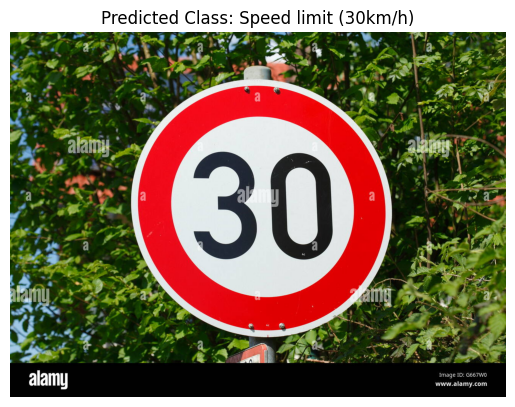

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


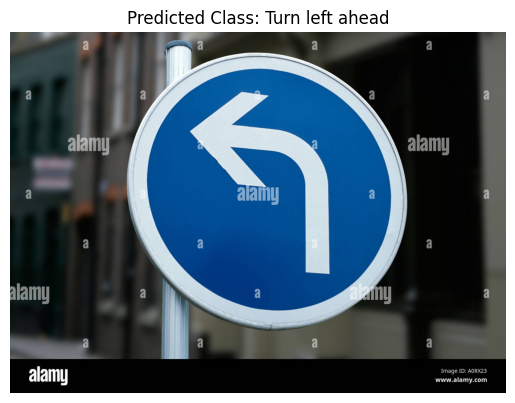

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


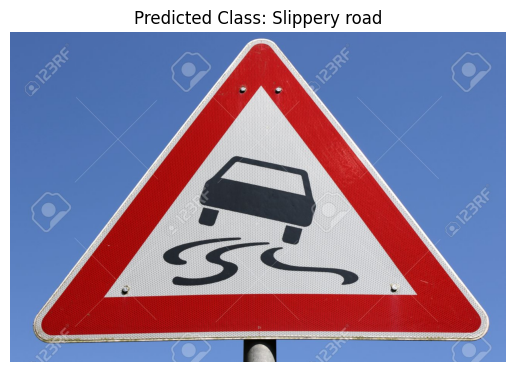

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


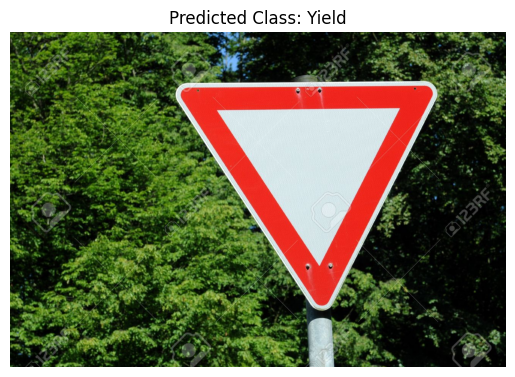

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


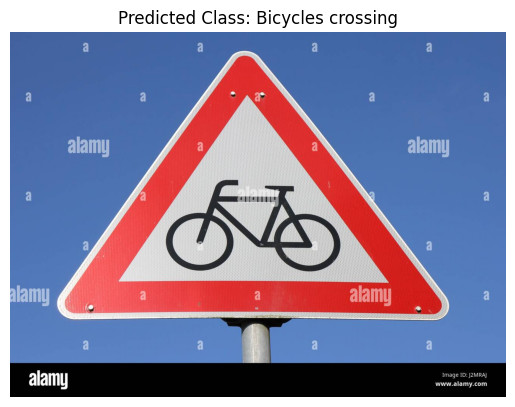

In [ ]:
# Again test the model with those 5 images and see how many of them are correctly classified now.
predict_and_display(model, image_urls)

Hence, successfully trained the model to classify and predict the traffic signs.